# Geospatial Analysis & Station Clustering
Objective: The goal is to analyze station usage through visualizations and clustering. This includes identifying the top stations by number of rides and creating clusters based on station usage using K-Means Machine Learning Algorithm. The insights gained will aid in planning for station expansion, upgrades, maintenance, and the placement of new stations.

Approach:
- Feature Selection: Number of rides starting at each station
- Feature Extraction: Ride Duration, Peak Usage Time
- Algorithm: K-Means

#### Import libraries

In [1]:
# Data manipulation packages
import pandas as pd
import numpy as np
import re

# Data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns 
import folium

# Math
from scipy import stats

# Important tools for modeling and evaluation.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

#### Import data

In [2]:
# Import all the monthly csv dataset
nov_20 = pd.read_csv(r"./202011-divvy-tripdata.csv")
dec_20 = pd.read_csv(r'./202012-divvy-tripdata.csv')
jan_21 = pd.read_csv(r'./202101-divvy-tripdata.csv')
feb_21 = pd.read_csv(r'./202102-divvy-tripdata.csv')
march_21 = pd.read_csv(r'./202103-divvy-tripdata.csv')
april_21 = pd.read_csv(r'./202104-divvy-tripdata.csv')
may_21 = pd.read_csv(r'./202105-divvy-tripdata.csv')
jun_21 = pd.read_csv(r'./202106-divvy-tripdata.csv')
july_21 = pd.read_csv(r'./202107-divvy-tripdata.csv')
aug_21 = pd.read_csv(r'./202108-divvy-tripdata.csv')
sept_21 = pd.read_csv(r'./202109-divvy-tripdata.csv')
oct_21 = pd.read_csv(r'./202110-divvy-tripdata.csv')
nov_21 = pd.read_csv(r'./202111-divvy-tripdata.csv')

# Join all months into a single dataframe
months = [nov_20, dec_20, jan_21, feb_21, march_21, april_21, may_21, jun_21, july_21, aug_21, sept_21, oct_21, nov_21]
df_months = pd.concat(months)

# Get basic information
df_months.head()


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,BD0A6FF6FFF9B921,electric_bike,2020-11-01 13:36:00,2020-11-01 13:45:40,Dearborn St & Erie St,110.0,St. Clair St & Erie St,211.0,41.894177,-87.629127,41.894434,-87.623379,casual
1,96A7A7A4BDE4F82D,electric_bike,2020-11-01 10:03:26,2020-11-01 10:14:45,Franklin St & Illinois St,672.0,Noble St & Milwaukee Ave,29.0,41.890959,-87.635343,41.900675,-87.662480,casual
2,C61526D06582BDC5,electric_bike,2020-11-01 00:34:05,2020-11-01 01:03:06,Lake Shore Dr & Monroe St,76.0,Federal St & Polk St,41.0,41.880983,-87.616754,41.872054,-87.629550,casual
3,E533E89C32080B9E,electric_bike,2020-11-01 00:45:16,2020-11-01 00:54:31,Leavitt St & Chicago Ave,659.0,Stave St & Armitage Ave,185.0,41.895499,-87.682013,41.917744,-87.691392,casual
4,1C9F4EF18C168C60,electric_bike,2020-11-01 15:43:25,2020-11-01 16:16:52,Buckingham Fountain,2.0,Buckingham Fountain,2.0,41.876497,-87.620358,41.876448,-87.620338,casual


In [3]:
# Check the number of data points
print(f'Number of data points: {df_months.shape[0]}')

# Check for duplicates
print(f'Number of duplicates {df_months.duplicated().sum()}')

# Check for missing values
df_months.isnull().sum()

Number of data points: 5738812
Number of duplicates 0


ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    675769
start_station_id      675876
end_station_name      725658
end_station_id        725735
start_lat                  0
start_lng                  0
end_lat                 5022
end_lng                 5022
member_casual              0
dtype: int64

In [4]:
# Drop the rows with missing values
# df_months = df_months.dropna(axis=0).reset_index(drop=True)

# Sort the datafrane by latitude and longitude
df_months = df_months.sort_values(by=['start_lat','start_lng'], ascending=True)

# Apply the forward fill
df_months = df_months.ffill()

# Apply backward fill
df_months = df_months.bfill()

# Reset index
df_months = df_months.reset_index(drop=True)

# Check the number of data points after dropping missing values
print(f'Number of data points: {df_months.shape[0]}')

Number of data points: 5738812


#### Data Processing
- Convert data type
- Calculate ride duration

In [5]:
# Check data type
df_months.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5738812 entries, 0 to 5738811
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 569.2+ MB


We need to convert the 'started_at and ended_at' string to a datetime. But to do that we need to make sure the string object are in the right format or else we get an error during conversion.

In [6]:
# Funtion to preprocess datetime string, adding seconds if missing
def preprocess_datetime(dt_str):
    if pd.isna(dt_str):
        return np.nan
    if len(dt_str) == 16:  # Format is missing seconds (YYYY-MM-DD HH:MM)
        return dt_str + ':00'
    # Add leading zero to single-digit hours
    if len(dt_str) == 15 and re.match(r'\d{4}-\d{2}-\d{2} \d:\d{2}', dt_str):
        return dt_str[:11] + '0' + dt_str[11:] + ':00'
    
    # Add leading zero to single-digit hours with missing seconds
    if len(dt_str) == 14 and re.match(r'\d{4}-\d{2}-\d{2} \d:\d{2}', dt_str):
        return dt_str[:11] + '0' + dt_str[11:] + ':00'
    return dt_str

# Apply the preprocessing function to both columns
df_months['started_at'] = df_months['started_at'].apply(preprocess_datetime)
df_months['ended_at'] = df_months['ended_at'].apply(preprocess_datetime)

# Convert to date time
df_months['started_at'] = pd.to_datetime(df_months['started_at'],format='%Y-%m-%d %H:%M:%S')
df_months['ended_at'] = pd.to_datetime(df_months['ended_at'],format='%Y-%m-%d %H:%M:%S')

#### Data Extraction

In [7]:
# start day of the week [Mon, Tue]
df_months['day'] = df_months['started_at'].dt.day_name()

# start time, from this we can determine if Morn, Afternoon, Night 
df_months['start_time'] = df_months['started_at'].dt.strftime('%H:%M:%S')
df_months['end_time'] = df_months['ended_at'].dt.strftime('%H:%M:%S') # Time when rides ended 

# month
df_months['month'] = df_months['started_at'].dt.strftime("%b-%y")

# Find the ride duration is seconds
df_months['ride_duration'] = (df_months['ended_at']-df_months['started_at']).dt.total_seconds()

# Get basic descriptive stats on the duration
df_months['ride_duration'].describe()

count    5.738812e+06
mean     1.208008e+03
std      1.752267e+04
min     -1.742998e+06
25%      4.090000e+02
50%      7.250000e+02
75%      1.318000e+03
max      3.356649e+06
Name: ride_duration, dtype: float64

#### Data Cleaning
For data cleaning, we will be using box plot

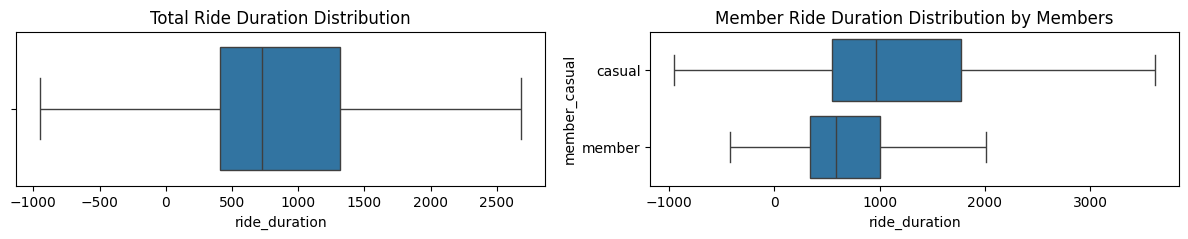

Interquartile range: 909.0
Lower Bound: -954.5
Upper Bound: 2681.5
Mean: 1208.0079748212697


In [8]:
fig, axes = plt.subplots(1, 2, figsize = (15,2))

# Plot 1
sns.boxplot(ax=axes[0], x=df_months['ride_duration'], showfliers = False)
axes[0].set_title('Total Ride Duration Distribution')

# Plot 2
sns.boxplot(ax=axes[1], x = df_months['ride_duration'], y = df_months['member_casual'], showfliers = False)
axes[1].set_title('Member Ride Duration Distribution by Members')
plt.show()

p25 = df_months['ride_duration'].quantile(0.25) # 25th percentile
p50 = df_months['ride_duration'].quantile(0.5) # 50th percentile
p75 = df_months['ride_duration'].quantile(0.75) # 75th percentile

# Interquartile range
iqr = p75 - p25
print(f'Interquartile range: {iqr}')

# Lower Limit
lower_bound  = p25 - 1.5 * iqr
print(f'Lower Bound: {lower_bound}')

# Upper Limit
upper_bound = p75 + 1.5 * iqr
print(f'Upper Bound: {upper_bound}')

# Mean
print(f'Mean: {df_months['ride_duration'].mean()}')

Eliminate outliers

In [9]:
# Eliminate outliers above the upper bound and negative ride durations
df_clean = df_months[(df_months['ride_duration'] >= 0) & (df_months['ride_duration'] <= upper_bound)]

print(f'No of data points after cleaning: {df_clean.shape[0]}')
print(f'Percentage of outliers dropped: {((df_months.shape[0] - df_clean.shape[0])/df_months.shape[0])*100}%')

No of data points after cleaning: 5313422
Percentage of outliers dropped: 7.412509766829791%


# Station Clustering
- Feature Selection: Use features like the number of rides starting/ending at each station, average ride duration, and peak usage times.
- Outcome: Identify stations with similar usage patterns, which can help in planning for station upgrades, maintenance, or new station placements.

Feature Selection

### START STATION CLUSTERING

#### Feature Selection
Keep only needed columns for clustering

In [10]:
df = df_clean
cluster_df = df.drop(['started_at','rideable_type','ended_at','start_station_id','end_station_name','day',
                      'end_station_id','start_lat','start_lng','end_lat', 'end_lng','end_time', 'month','member_casual'],
                      axis = 1)
cluster_df.head()

,ride_id,start_station_name,start_time,ride_duration
4,DE82A15026BA3056,Hegewisch Metra Station,18:18:59,169.0
5,F355A001C7552ADD,Hegewisch Metra Station,14:18:00,1620.0
6,23FE33AEC9C13C9C,Hegewisch Metra Station,10:53:14,1392.0
7,0744ADDD14D52471,Hegewisch Metra Station,11:01:20,1347.0
8,4640F42D34E739E9,Hegewisch Metra Station,16:12:25,2016.0


#### Feature Extraction
Assign peak period based on the 'start_time' - Morning Afternoon Evening

In [11]:
# Define function to assign peak times from start time

def day_period(time_str):
    hour = int(time_str.split(':')[0])
    if 0 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'

# Apply the function to the 'start_time' column
cluster_df['time_of_day'] = cluster_df['start_time'].apply(day_period)

# find the count of each time of day
cluster_df['time_of_day'].value_counts()

time_of_day
Afternoon    2327795
Night        1508751
Morning      1476876
Name: count, dtype: int64

#### Feature Transformation
Peak Time -  Morn, After, Night

In [12]:
# Create a mapping of days to numerical values
daily_period = {
    'Morning':0,
    'Afternoon':1,
    'Night':2
}

cluster_df['daily_period'] = cluster_df['time_of_day'].map(daily_period)
cluster_df.head()

,ride_id,start_station_name,start_time,ride_duration,time_of_day,daily_period
4,DE82A15026BA3056,Hegewisch Metra Station,18:18:59,169.0,Night,2
5,F355A001C7552ADD,Hegewisch Metra Station,14:18:00,1620.0,Afternoon,1
6,23FE33AEC9C13C9C,Hegewisch Metra Station,10:53:14,1392.0,Morning,0
7,0744ADDD14D52471,Hegewisch Metra Station,11:01:20,1347.0,Morning,0
8,4640F42D34E739E9,Hegewisch Metra Station,16:12:25,2016.0,Afternoon,1


In [13]:
# Get each stations peak period in a day
df_day = cluster_df.groupby(['start_station_name','daily_period']).agg({'ride_id':['count']}).reset_index()
df_day.columns = df_day.columns.droplevel()
df_day.rename(columns={'':'start_station_name'}, inplace=True)
df_day.columns.values[[1,2]] = ['peak_daily_period','day_ride_count']

df_day_ride = df_day.loc[df_day.groupby('start_station_name')['day_ride_count'].idxmax()].reset_index(drop=True)
df_day_ride.drop(columns=['day_ride_count'], inplace=True)

# Get the number of rides and the average ride duration of rides from each station
df_cluster = cluster_df.groupby('start_station_name').agg({'ride_id':['count'], 'ride_duration':['mean']}).reset_index()
df_cluster.columns = df_cluster.columns.droplevel()
df_cluster.rename(columns={'':'start_station_name'}, inplace=True)
df_cluster.columns.values[[1,2]] = ['ride_count','avg_ride_duration']

# Merge
df_day_cluster = df_cluster.merge(df_day_ride, left_on = 'start_station_name', right_on='start_station_name', how= 'left')

#### Encode Data

In [14]:
# Convert 'peak daily period' categorical columns to numeric
df_period_peak = pd.get_dummies(df_day_cluster, drop_first=True, columns = ['peak_daily_period'], dtype = 'int')
df_period_peak.head()

,start_station_name,ride_count,avg_ride_duration,peak_daily_period_1,peak_daily_period_2
0,2112 W Peterson Ave,1073,982.326188,1,0
1,351,2,1662.000000,1,0
2,63rd St Beach,1551,1385.460348,1,0
3,900 W Harrison St,8254,687.455779,1,0
4,Aberdeen St & Jackson Blvd,12218,692.324358,1,0


#### Scale Features

In [15]:
# Exclude columns
X = df_period_peak.drop(['start_station_name','avg_ride_duration'], axis=1)

# Scale the features
X_scaled = StandardScaler().fit_transform(X)

#### Data Modelling

Determining Optimum number of Clusters (Elbow Method)
- For this method, the dataset is fit with the k-means model for a range of values (2-10). The distortions for each value of k is stored and then plotted on a line chart. The point of inflection is a good indication that the model fits best at that point.

Text(0, 0.5, 'Inertia')

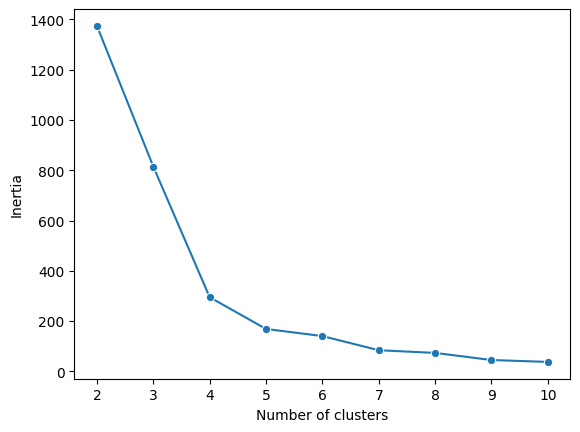

In [16]:
# Fit K-means and evaluate inertia for differnt values of k

num_clusters = [i for i in range(2,11)]

def kmeans_inertia(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints. 
    Returns each k-value's inertia appended to a list.
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)

    return inertia

# Return a list of inertia for k=2 to 10
inertia = kmeans_inertia(num_clusters, X_scaled)

plot = sns.lineplot(x=num_clusters, y=inertia, marker ='o')
plot.set_xlabel("Number of clusters")
plot.set_ylabel("Inertia")

#### Results and Evaluation

Text(0, 0.5, 'Silhouette Score')

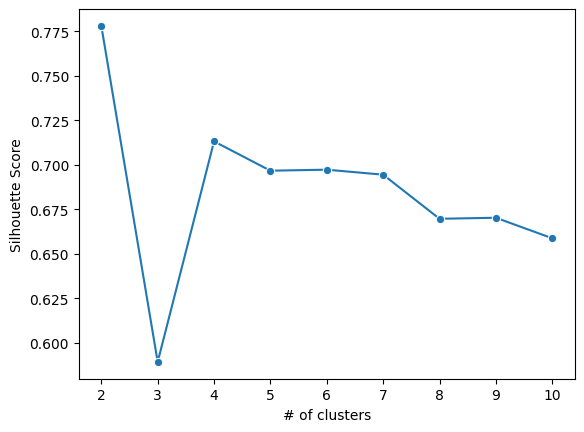

In [17]:
# Evaluate silhouette score
# Function to return a list of each k-value's score

def kmeans_sil(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value. 
    Returns each k-value's silhouette score appended to a list.
    """
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))

    return sil_score

sil_score = kmeans_sil(num_clusters, X_scaled)

plot = sns.lineplot(x=num_clusters, y=sil_score, marker = 'o')
plot.set_xlabel("# of clusters")
plot.set_ylabel("Silhouette Score")

#### Optimal k-value

In [18]:
# Fit a 4-cluster model
kmeans4 = KMeans(n_clusters= 4, random_state=42)
kmeans4.fit(X_scaled)

KMeans(n_clusters=4, random_state=42)

In [19]:
# Print unique labels
print('Unique labels:', np.unique(kmeans4.labels_))

Unique labels: [0 1 2 3]


Create a cluster column that indicates cluster assignment

In [20]:
# Create a cluster column
df_period_peak['cluster'] = kmeans4.labels_
df_period_peak.head()

,start_station_name,ride_count,avg_ride_duration,peak_daily_period_1,peak_daily_period_2,cluster
0,2112 W Peterson Ave,1073,982.326188,1,0,0
1,351,2,1662.000000,1,0,0
2,63rd St Beach,1551,1385.460348,1,0,0
3,900 W Harrison St,8254,687.455779,1,0,0
4,Aberdeen St & Jackson Blvd,12218,692.324358,1,0,2


#### Plot the clusters

In [21]:
# The each station's position (latitude and longitude)
station_post = df.groupby('start_station_name').agg({'start_lat':['mean'], 'start_lng':['mean']}).reset_index()
station_post.columns = station_post.columns.droplevel()
station_post.rename(columns={'':'start_station_name'}, inplace=True)
station_post.columns.values[[1,2]] = ['start_lat','start_lng']

# Merge with the cluster dataframe
df_station_post = df_period_peak.merge(station_post, left_on = 'start_station_name', right_on='start_station_name', how='left')
df_station_post.head(2)

,start_station_name,ride_count,avg_ride_duration,peak_daily_period_1,peak_daily_period_2,cluster,start_lat,start_lng
0,2112 W Peterson Ave,1073,982.326188,1,0,0,41.991175,-87.683592
1,351,2,1662.000000,1,0,0,41.930000,-87.780000


In [22]:
def cluster(num):

    # Filter
    df = df_station_post[df_station_post['cluster'] == num].reset_index(drop=True)

    return df

# Filter clusters
df_cluster0 = cluster(0)
df_cluster1 = cluster(1)
df_cluster2 = cluster(2)
df_cluster3 = cluster(3)

#### Colour Legend
- Beige - Cluster 0
- Dark Green - Cluster 1
- Red - Cluster 2
- Blue - CCluster 3

In [23]:
# Plot
mapit = folium.Map(location = [df['start_lat'].mean(), df['start_lng'].mean()], zoom_start=10)

for i in range(0,30):
    # Cluster O plot
    folium.Marker(location = [df_cluster0.iloc[i]['start_lat'], df_cluster0.iloc[i]['start_lng']],
                  icon = folium.Icon(color='beige'), 
                  popup=df_cluster0.iloc[i]['start_station_name'],
                  radius=8).add_to(mapit)
    # Cluster 1 plot
    folium.Marker(location = [df_cluster1.iloc[i]['start_lat'], df_cluster1.iloc[i]['start_lng']],
                  icon = folium.Icon(color='darkgreen'), 
                  popup=df_cluster1.iloc[i]['start_station_name'],
                  radius=8).add_to(mapit)
    # Cluster 2 plot
    folium.Marker(location = [df_cluster2.iloc[i]['start_lat'], df_cluster2.iloc[i]['start_lng']],
                  icon = folium.Icon(color='red'), 
                  popup=df_cluster2.iloc[i]['start_station_name'],
                  radius=8).add_to(mapit)
    # Cluster 3 plot
    folium.Marker(location = [df_cluster3.iloc[i]['start_lat'], df_cluster3.iloc[i]['start_lng']],
                  icon = folium.Icon(color='blue'), 
                  popup=df_cluster3.iloc[i]['start_station_name'],
                  radius=8).add_to(mapit)
   
# Show viz
mapit

    

In [24]:
# Group the cluster to see number of stations in each cluster and the total number of rides from each station
df_station_post.groupby('cluster').agg({'ride_count':['sum','count']}).reset_index()

cluster ride_count      
                 sum count
0       0    1559880   562
1       1     142720    38
2       2    3507239   189
3       3     103583    57

### Summary
The start station clustering results reveal four distinct clusters, each characterized by the total number of rides and the number of stations within each cluster. Here's a detailed breakdown:

- Cluster 0 [Beige]
Total Ride Count: 1,559,880
Number of Stations: 562
Average Rides per Station: 2,776
- Cluster 1 [Green]
Total Ride Count: 142,720
Number of Stations: 38
Average Rides per Station: 3,755
- Cluster 2 [Red]
Total Ride Count: 3,507,239
Number of Stations: 189
Average Rides per Station: 18,559
- Cluster 3 [Blue]
Total Ride Count: 103,583
Number of Stations: 57
Average Rides per Station: 1,817


Insights:
- Cluster 2 has the highest total ride count and the highest average rides per station, indicating that these stations are the most popular and heavily used in the bike-sharing network.
- Cluster 0 has a substantial total ride count but spread across a large number of stations, suggesting moderate usage across many stations.
- Cluster 1 has relatively fewer stations but a higher average rides per station than Cluster 0, pointing to more concentrated usage at these stations.
- Cluster 3 shows the lowest total ride count and average rides per station, indicating these stations are the least used in the network.

Implications for Bike-Sharing Operations:
Cluster 2 stations might require more maintenance and frequent bike rebalancing due to high usage.
Cluster 0 and Cluster 1 stations might benefit from targeted promotions or infrastructure improvements to balance the load and potentially increase usage.
Cluster 3 stations may need further investigation to understand the low usage and explore ways to enhance their attractiveness or accessibility.

## END STATION CLUSTERING

#### Feature Selection

In [25]:
cluster_end_df = df.drop(['started_at','start_station_name','rideable_type','ended_at','start_station_id',
                      'end_station_id','start_lat','start_lng','end_lat', 'end_lng','start_time','member_casual', 'month'],
                      axis = 1)
cluster_end_df.head(2)

,ride_id,end_station_name,day,end_time,ride_duration
4,DE82A15026BA3056,Hegewisch Metra Station,Tuesday,18:21:48,169.0
5,F355A001C7552ADD,Burnham Greenway & 105th St,Thursday,14:45:00,1620.0


#### Feature Extraction

In [26]:
# Define function to assign peak times from start time

def day_period(time_str):
    hour = int(time_str.split(':')[0])
    if 0 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'

# Apply the function to the 'start_time' column
cluster_end_df['time_of_day'] = cluster_end_df['end_time'].apply(day_period)

# find the count of each time of day
cluster_end_df['time_of_day'].value_counts()

time_of_day
Afternoon    2275489
Night        1607492
Morning      1430441
Name: count, dtype: int64

#### Feature Transformation

In [27]:
cluster_end_df['daily_period'] = cluster_end_df['time_of_day'].map(daily_period)

# Get each stations peak period in a day
df_day = cluster_end_df.groupby(['end_station_name','daily_period']).agg({'ride_id':['count']}).reset_index()
df_day.columns = df_day.columns.droplevel()
df_day.rename(columns={'':'end_station_name'}, inplace=True)
df_day.columns.values[[1,2]] = ['peak_daily_period','day_ride_count']

df_day_ride = df_day.loc[df_day.groupby('end_station_name')['day_ride_count'].idxmax()].reset_index(drop=True)
df_day_ride.drop(columns=['day_ride_count'], inplace=True)

# Get the number of rides and the average ride duration of rides from each station
df_cluster = cluster_end_df.groupby('end_station_name').agg({'ride_id':['count'], 'ride_duration':['mean']}).reset_index()
df_cluster.columns = df_cluster.columns.droplevel()
df_cluster.rename(columns={'':'end_station_name'}, inplace=True)
df_cluster.columns.values[[1,2]] = ['ride_count','avg_ride_duration']

# Merge
df_day_cluster = df_cluster.merge(df_day_ride, left_on = 'end_station_name', right_on='end_station_name', how= 'left')

#### Encode Data

In [28]:
# Convert 'peak daily period' categorical columns to numeric
df_period_peak = pd.get_dummies(df_day_cluster, drop_first=True, columns = ['peak_daily_period'], dtype='int')
df_period_peak.head()

,end_station_name,ride_count,avg_ride_duration,peak_daily_period_1,peak_daily_period_2
0,2112 W Peterson Ave,1409,930.361249,1,0
1,63rd St Beach,1924,1233.077963,1,0
2,900 W Harrison St,8726,678.067729,1,0
3,Aberdeen St & Jackson Blvd,20407,723.719508,1,0
4,Aberdeen St & Monroe St,11712,765.455943,1,0


#### Scale Features

In [29]:
# Exclude columns
X = df_period_peak.drop(['end_station_name','avg_ride_duration'], axis=1)

# Scale the features
X_scaled = StandardScaler().fit_transform(X)

#### Data Modelling

Text(0, 0.5, 'Inertia')

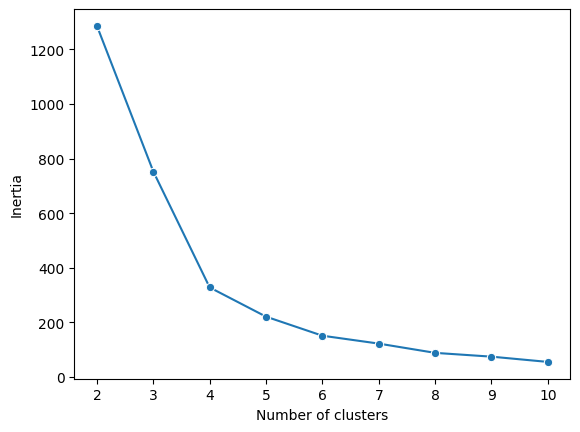

In [30]:
# Fit K-means and evaluate inertia for differnt values of k

num_clusters = [i for i in range(2,11)]

def kmeans_inertia(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints. 
    Returns each k-value's inertia appended to a list.
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)

    return inertia

# Return a list of inertia for k=2 to 10
inertia = kmeans_inertia(num_clusters, X_scaled)
plot = sns.lineplot(x=num_clusters, y=inertia, marker ='o')
plot.set_xlabel("Number of clusters")
plot.set_ylabel("Inertia")

#### Results and Evaluation

Text(0, 0.5, 'Silhouette Score')

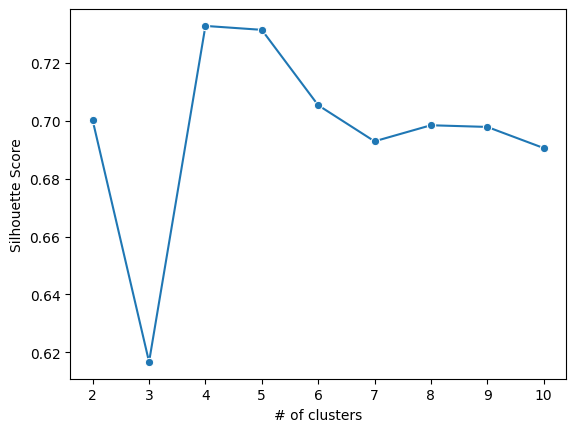

In [31]:
# Evaluate silhouette score
# Function to return a list of each k-value's score

def kmeans_sil(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value. 
    Returns each k-value's silhouette score appended to a list.
    """
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))

    return sil_score


sil_score = kmeans_sil(num_clusters, X_scaled)
plot = sns.lineplot(x=num_clusters, y=sil_score, marker = 'o')
plot.set_xlabel("# of clusters")
plot.set_ylabel("Silhouette Score")

#### Optimal k-value

In [32]:
# Fit a 4-cluster model
kmeans4 = KMeans(n_clusters= 4, random_state=42)
kmeans4.fit(X_scaled)

KMeans(n_clusters=4, random_state=42)

In [33]:
# Create a cluster column
df_period_peak['cluster'] = kmeans4.labels_
df_period_peak.head()

,end_station_name,ride_count,avg_ride_duration,peak_daily_period_1,peak_daily_period_2,cluster
0,2112 W Peterson Ave,1409,930.361249,1,0,0
1,63rd St Beach,1924,1233.077963,1,0,0
2,900 W Harrison St,8726,678.067729,1,0,0
3,Aberdeen St & Jackson Blvd,20407,723.719508,1,0,2
4,Aberdeen St & Monroe St,11712,765.455943,1,0,0


#### Plot the cluster

In [34]:
# The each station's position (latitude and longitude)
station_post = df.groupby('end_station_name').agg({'end_lat':['mean'], 'end_lng':['mean']}).reset_index()
station_post.columns = station_post.columns.droplevel()
station_post.rename(columns={'':'end_station_name'}, inplace=True)
station_post.columns.values[[1,2]] = ['end_lat','end_lng']

# Merge with the cluster dataframe
df_station_post = df_period_peak.merge(station_post, left_on = 'end_station_name', right_on='end_station_name', how='left')
df_station_post.head(2)

,end_station_name,ride_count,avg_ride_duration,peak_daily_period_1,peak_daily_period_2,cluster,end_lat,end_lng
0,2112 W Peterson Ave,1409,930.361249,1,0,0,41.989258,-87.684320
1,63rd St Beach,1924,1233.077963,1,0,0,41.781919,-87.580125


In [35]:
def cluster(num):

    # Filter
    df = df_station_post[df_station_post['cluster'] == num].reset_index(drop=True)

    return df

# Filter clusters
df_cluster0 = cluster(0)
df_cluster1 = cluster(1)
df_cluster2 = cluster(2)
df_cluster3 = cluster(3)
df_cluster4 = cluster(4)

#### Colour Legend
- Dark Green - Cluster 0
- Blue - Cluster 1
- Red - Cluster 2
- Beige - CCluster 3

In [36]:
# Plot
mapit = folium.Map(location = [df['end_lat'].mean(), df['end_lng'].mean()], zoom_start=10)

for i in range(0,30):
    # Cluster O plot
    folium.Marker(location = [df_cluster0.iloc[i]['end_lat'], df_cluster0.iloc[i]['end_lng']],
                  icon = folium.Icon(color='darkgreen'), 
                  popup=df_cluster0.iloc[i]['end_station_name'],
                  radius=8).add_to(mapit)
    # Cluster 1 plot
    folium.Marker(location = [df_cluster1.iloc[i]['end_lat'], df_cluster1.iloc[i]['end_lng']],
                  icon = folium.Icon(color='blue'), 
                  popup=df_cluster1.iloc[i]['end_station_name'],
                  radius=8).add_to(mapit)
    # Cluster 2 plot
    folium.Marker(location = [df_cluster2.iloc[i]['end_lat'], df_cluster2.iloc[i]['end_lng']],
                  icon = folium.Icon(color='red'), 
                  popup=df_cluster2.iloc[i]['end_station_name'],
                  radius=8).add_to(mapit)
    # Cluster 3 plot
    folium.Marker(location = [df_cluster3.iloc[i]['end_lat'], df_cluster3.iloc[i]['end_lng']],
                  icon = folium.Icon(color='beige'), 
                  popup=df_cluster3.iloc[i]['end_station_name'],
                  radius=8).add_to(mapit)
# Show viz
mapit
    

In [37]:
# Group the cluster to see number of stations in each cluster and the total number of rides from each station
df_station_post.groupby('cluster').agg({'ride_count':['sum','count']})

ride_count      
               sum count
cluster                 
0          1506503   526
1           254175    86
2          3197156   147
3           355588    81

### Summary
- Cluster 0 [Green]
Total Ride Count: 1,506,503 rides
Number of Stations: 526 stations
Average Rides per Station: Approximately 2,863 rides per station
- Cluster 1 [Blue]
Total Ride Count: 254,175 rides
Number of Stations: 86 stations
Average Rides per Station: Approximately 2,956 rides per station
- Cluster 2 [Red]
Total Ride Count: 3,197,156 rides
Number of Stations: 147 stations
Average Rides per Station: Approximately 21,747 rides per station
- Cluster 3 [Beige]
Total Ride Count: 355,588 rides
Number of Stations: 81 stations
Average Rides per Station: Approximately 4,389 rides per station

Insights
- Cluster 2 stands out as the busiest cluster with the highest total ride count and a significantly higher average rides per station compared to other clusters. This cluster likely includes major hubs and popular destinations with high foot traffic.
- Cluster 1 has the lowest total ride count, yet it has a relatively high average rides per station, suggesting that these stations, though fewer in number, serve a moderate volume of users consistently.
- Cluster 0 has the highest number of stations but a moderate total ride count and the lowest average rides per station. This indicates a wide distribution of usage with many stations serving fewer riders.
- Cluster 3 features a higher average rides per station than Clusters 0 and 1 but significantly fewer total rides than Cluster 2, pointing to a concentrated area of moderately high usage.